In [25]:

# Libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [26]:
import datetime
!pip install yfinance
import yfinance as yf
start = datetime.datetime(2012,1,1)
end = datetime.datetime(2019,12,17)
df = yf.download('aapl',start=start, end=end)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.575916,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.643500,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.783870,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.917513,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.897021,394024400
...,...,...,...,...,...,...
2019-12-10,67.150002,67.517502,66.464996,67.120003,66.053436,90420400
2019-12-11,67.202499,67.775002,67.125000,67.692497,66.616829,78756800
2019-12-12,66.945000,68.139999,66.830002,67.864998,66.786583,137310400


In [27]:
df.shape

(2002, 6)

Text(0, 0.5, 'Price $')

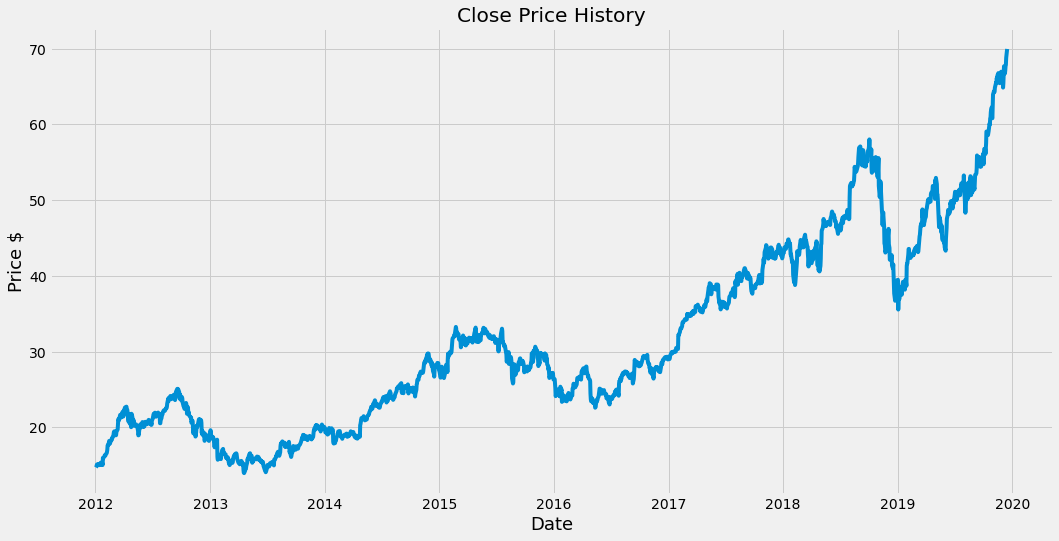

In [28]:
#visualize closing price
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price $', fontsize=18)

In [29]:
# Create a new df with only the close 
data = df.filter(['Close'])
dataset = data.values
dataset

array([[14.6867857 ],
       [14.76571369],
       [14.92964268],
       ...,
       [67.86499786],
       [68.78749847],
       [69.96499634]])

In [30]:
#scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.0131974 ],
       [0.01460639],
       [0.01753278],
       ...,
       [0.96251174],
       [0.97897982],
       [1.        ]])

In [31]:
# create train data
training_len = math.ceil(len(dataset) * .8)
train_data = scaled_data[0:training_len , :]
# split data
x_train = []
y_train = []
days = 120
for i in range(days, len(train_data)):
  x_train.append(train_data[i-days:i,0])
  y_train.append(train_data[i,0]) 


In [32]:
# convert to numpy so we can use them for th Lstm model
x_train, y_train = np.array(x_train), np.array(y_train)

In [33]:
#reshape the data to 3D for Lstm model
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1], 1))
x_train.shape

(1482, 120, 1)

In [34]:
# Build the model
model = Sequential()
model.add(LSTM(50, return_sequences=True,input_shape= (x_train.shape[1],1))) # (60,1)
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [35]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [36]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1482/1482 [==============================] - 105s 68ms/step - loss: 7.9996e-04


In [37]:
# Create test data
test_data = scaled_data[training_len - days: , :] # (1543, 2003)

x_test = []
y_test = dataset[training_len:, :]

for i in range(days, len(test_data)):
  x_test.append(test_data[i-days:i, 0])
  

In [38]:
#Convert to numpy
x_test = np.array(x_test)

In [39]:
#Reshape
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [40]:
# Predict
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) # invert the scaling. actual values



In [41]:
# Evaluate modeL with RMSE
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse


1.3605752658843995

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


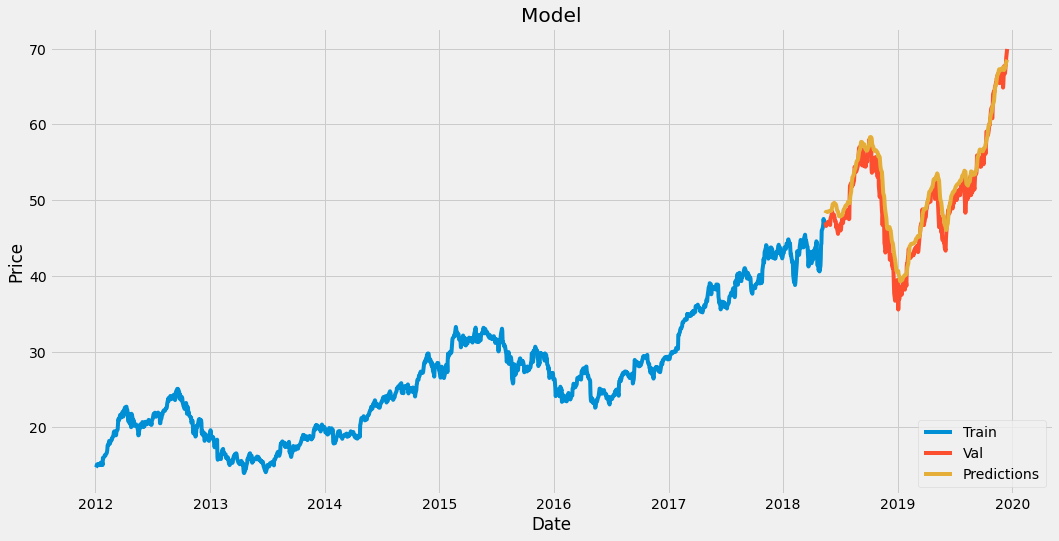

In [42]:
#Plot the data
train = data[:training_len]
valid = data[training_len:]
valid['Predictions'] = predictions
# Visualization
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()